# Macquarie marshes

In [1]:
%matplotlib inline

import sys
import datacube
import skimage.exposure
import geopandas as gpd
import matplotlib.pyplot as plt
from IPython.display import Image
import xarray as xr
import numpy as np
import scipy.ndimage
import odc.algo.io
import shapely
import dask

sys.path.append('../Scripts')
from dea_plotting import rgb
from dea_bandindices import calculate_indices
from dea_datahandling import load_ard, mostcommon_crs
# from dea_plotting import xr_animation

In [2]:
time_bounds = ('2009-01-01', '2021-12-31')

In [3]:
ramsars = gpd.read_file('macquariemarshes.geojson')

In [4]:
dc = datacube.Datacube(app='MacquarieMarshesAnimation')

In [5]:
landsat_query = {'x': (147.21809, 147.93664),  
         'y': (-30.30421, -31.08933),
         'measurements': ['nbart_red', 
                          'nbart_green', 
                          'nbart_blue',
                          'nbart_nir',
                          'nbart_swir_1',
                          'nbart_swir_2',
                          'fmask'],
        'time': time_bounds}

In [6]:
s2_query = landsat_query.copy()
s2_query['measurements'] = ['nbart_red', 
                            'nbart_green', 
                            'nbart_blue',
                            'nbart_nir_1',
                            'nbart_swir_2',
                            'nbart_swir_3',
                            'fmask']

In [7]:
landsat_products = ['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3']
s2_products = ['s2a_ard_granule', 's2b_ard_granule']

In [8]:
# landsat_crs = mostcommon_crs(dc, landsat_products[0], {k:v for k, v in landsat_query.items() if k not in {'resampling', 'align'}})
landsat_crs = 'EPSG:32655'

In [9]:
x = landsat_query['x']
y = landsat_query['y']
bbox = shapely.geometry.Polygon([(x[0], y[0]), (x[1], y[0]), (x[1], y[1]), (x[0], y[1])])
geobox = datacube.utils.geometry.GeoBox.from_geopolygon(datacube.utils.geometry.Geometry(bbox, crs='EPSG:4326'), resolution=(-0.0008, 0.0008))

dss_landsat = dc.find_datasets(product=landsat_products, **landsat_query)

Time to do some advanced data loading to get around an ODC bug:

In [10]:
ds_landsat_raw = odc.algo.io.load_with_native_transform(dss_landsat, bands=landsat_query['measurements'], geobox=geobox, native_transform=lambda x: x, dask_chunks={})
ds_landsat_grouped = ds_landsat_raw.where(ds_landsat_raw > -999).groupby('solar_day').mean()

In [11]:
ds_landsat_grouped_fmask = ((ds_landsat_raw.fmask == 1) | (ds_landsat_raw.fmask == 5)).groupby('solar_day').sum() > 0

In [12]:
n_ok = ds_landsat_grouped_fmask.sum(axis=(1, 2))
n_ok = n_ok.load()
n_pixels = geobox.width * geobox.height
pc_ok = n_ok / n_pixels
ok_ls = pc_ok >= 0.85

In [13]:
ds_landsat_grouped = ds_landsat_grouped.isel(solar_day=ok_ls)

In [14]:
dss_s2 = dc.find_datasets(product=s2_products, **s2_query)

In [15]:
try:
    ds_s2_raw = odc.algo.io.load_with_native_transform(dss_s2, bands=s2_query['measurements'], geobox=geobox, native_transform=lambda x: x, dask_chunks={})
except ValueError:
    ds_s2_raw = None

In [16]:
if ds_s2_raw is not None:
    ds_s2_grouped = ds_s2_raw.where(ds_s2_raw > -999).groupby('solar_day').mean()

    ds_s2_grouped_fmask = ((ds_s2_raw.fmask == 1) | (ds_s2_raw.fmask == 5)).groupby('solar_day').sum() > 0

    n_ok = ds_s2_grouped_fmask.sum(axis=(1, 2))
    n_ok = n_ok.load()
    n_pixels = geobox.width * geobox.height
    pc_ok = n_ok / n_pixels
    ok_s2 = pc_ok >= 0.85
    ds_s2_grouped = ds_s2_grouped.isel(solar_day=ok_s2)

    ds_s2_grouped_fmask = ds_s2_grouped_fmask.isel(solar_day=ok_s2)
else:
    ds_s2_grouped = None

In [17]:
ds_landsat_grouped_fmask = ds_landsat_grouped_fmask.isel(solar_day=ok_ls)

Rename S2 to match Landsat bands. `nir_1` -> `nir`, `swir_2` -> `swir_1`.

In [18]:
ds_s2 = ds_s2_grouped
ds_landsat = ds_landsat_grouped

In [19]:
if ds_s2 is not None:
    ds_s2['nbart_nir'] = ds_s2['nbart_nir_1']
    ds_s2['nbart_swir_1'] = ds_s2['nbart_swir_2']
    del ds_s2['nbart_nir_1']
    del ds_s2['nbart_swir_2']

In [20]:
if ds_s2 is not None:
    ds_s2['nbart_swir_2'] = ds_s2['nbart_swir_3']
    del ds_s2['nbart_swir_3']

In [21]:
if ds_s2 is not None:
    ds_combined = xr.concat([ds_landsat, ds_s2], dim='solar_day')
    ds_combined_fmask = xr.concat([ds_landsat_grouped_fmask, ds_s2_grouped_fmask], dim='solar_day')
else:
    ds_combined = ds_landsat
    ds_combined_fmask = ds_landsat_grouped_fmask

In [22]:
ds_combined = ds_combined.sortby('solar_day')

In [23]:
ds_combined_fmask = ds_combined_fmask.sortby('solar_day')

In [24]:
ramsar_gdfs = ramsars

In [25]:
ramsar_gdfs.reset_index(inplace=True, drop=True)

In [26]:
gdf_kwargs = {}
gdf_kwargs['facecolor'] = 'None'
gdf_kwargs['edgecolor'] = 'k'
gdf_kwargs['linewidth'] = 3

In [27]:
frames = gpd.pd.DataFrame(np.arange(len(ds_combined.solar_day)), index=gpd.pd.to_datetime(ds_combined.solar_day.values))

In [28]:
frames_ = frames.resample('1W').min()
frames = frames_.ffill().astype(int)

In [29]:
dup_ax = gpd.pd.Series(ds_combined.solar_day).duplicated()

In [30]:
ds_combined = ds_combined.isel(solar_day=~dup_ax)

In [31]:
ds_combined_fmask = ds_combined_fmask.isel(solar_day=~dup_ax)

In [32]:
ds_combined_fmask.load();

In [33]:
interp = ds_combined.where(ds_combined_fmask).resample(solar_day='1W').interpolate('linear')

In [34]:
interp = interp.ffill(dim='solar_day')

In [35]:
interp = interp.rename({'solar_day': 'time'})

Calculate the TCW index for all frames.

In [40]:
tcw = calculate_indices(interp, index='TCW', collection='ga_ls_3')

In [44]:
interp_arr = interp[['nbart_swir_1', 'nbart_nir', 'nbart_green']].to_array().values

/env/lib/python3.6/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [45]:
min_, max_ = np.nanpercentile(interp_arr, (2, 98))

In [46]:
import matplotlib

In [47]:
water_releases = [
    ('3/11/2009', '1/1/2010'),
    ('1/9/2010', '15/4/2011'),
    ('16/08/2011', '27/01/2012'),
    ('25/9/2012', '25/01/2013'),
    ('15/08/2013', '3/11/2013'),
    ('5/10/2014', '12/12/2014'),
    ('6/8/2015', '17/10/2015'),
    ('24/1/2017', '18/2/2017'),  # Jan - Feb
    ('4/4/2017', '12/4/2017'),  # Apr
    ('16/4/2017', '15/5/2017'),  # Apr - May
    ('19/7/2017', '14/8/2017'),  # Jul - Aug
    ('15/8/2017', '12/11/2017'),  # Aug - Nov
    ('24/7/2018', '11/12/2018'),
    # Then these periods overlap:
    ('19/3/2019',  '30/4/2019'),  # Mar - Apr
    ('30/4/2019', '25/5/2019'),  # Apr - May
    ('25/5/2019', '30/6/2019'),  # May - Jun
]
water_releases = [gpd.pd.to_datetime(w, dayfirst=True) for ws in water_releases for w in ws]

In [48]:
water_releases_supp = [
    ('2/1/2010', '4/1/2010'),
    ('22/1/2010', '23/1/2010'),
    ('3/8/2010', '12/8/2010'),
    ('13/8/2010', '16/8/2010'),
    ('25/6/2016', '30/6/2016'),
    ('13/7/2016', '16/7/2016'),
    ('24/7/2016', '30/7/2016'),
#     ('6/9/2016', '10/11/2016'),
    ('6/9/2016', '13/9/2016'),
    ('19/12/2016', '21/12/2016'),
    ('22/02/2020', '24/02/2020'),
    ('7/04/2020', '10/04/2020'),
    ('14/4/2020', '17/04/2020'),
    ('1/8/2020', '3/8/2020'),
]
water_releases_supp = [gpd.pd.to_datetime(w, dayfirst=True) for ws in water_releases_supp for w in ws]

In [49]:
water_amounts = [
    19283.2,
    135595,
    153480,
    265781,
    64659,
    28494,
    52554,
    46413,
    6481,
    27583,
    5939,
    128438,
    126477,
    150,
    800,
    150,
]
assert len(water_amounts) == len(water_releases) / 2

In [50]:
water_amounts_supp = [
    1000,
    500,
    1375,
    1955.4,
    2500,
    1426,
    3000,
    3500,
    750,
    1375,
    1583,
    1625,
    750,
]
assert len(water_amounts_supp) == len(water_releases_supp) / 2

In [51]:
xs, ys = [], []
for i in range(len(water_amounts)):
    x1 = water_releases[i * 2]
    x2 = water_releases[i * 2 + 1]
    y = water_amounts[i]
    y = y / (x2 - x1).days
    if xs and water_releases[i * 2] == xs[-1]:
        xs.pop()
        ys.pop()
        xs.extend([x1, x2, x2])
        ys.extend([y, y, 0])
    else:
        xs.extend([x1, x1, x2, x2])
        ys.extend([0, y, y, 0])
        
xs_supp, ys_supp = [], []
for i in range(len(water_amounts_supp)):
    x1 = water_releases_supp[i * 2]
    x2 = water_releases_supp[i * 2 + 1]
    y = water_amounts_supp[i]
    y = y / (x2 - x1).days
    if xs_supp and water_releases_supp[i * 2] == xs_supp[-1]:
        xs_supp.pop()
        ys_supp.pop()
        xs_supp.extend([x1, x2, x2])
        ys_supp.extend([y, y, 0])
    else:
        xs_supp.extend([x1, x1, x2, x2])
        ys_supp.extend([0, y, y, 0])

In [52]:
# MONKEYGAR CREEK AT U/S WESTERN ARM RETURN
macquarie_discharge = gpd.pd.read_csv('csv.w00077.20210129145252.421129.csv', comment='#', names=['date', 'value', 'qual', 'inte']).set_index('date')

In [53]:
macquarie_discharge.index = gpd.pd.to_datetime(macquarie_discharge.index)

In [54]:
m3_per_s_to_ML_per_day = 86.4

In [55]:
macquarie_discharge = macquarie_discharge * m3_per_s_to_ML_per_day

In [56]:
release_series = gpd.pd.Series(ys, index=xs)

In [57]:
release_series_supp = gpd.pd.Series(ys_supp, index=xs_supp)

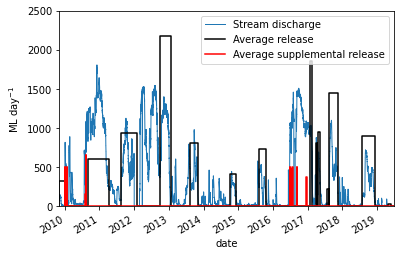

In [58]:
fig, ax = plt.subplots()
ax.set_ylabel('ML day$^{-1}$')
macquarie_discharge.value.plot(ax=ax, label='Stream discharge', lw=1)
release_series.plot(ax=ax, label='Average release', c='k')
release_series_supp.plot(ax=ax, label='Average supplemental release', c='red')
ax.set_xlim(release_series.index[0], release_series.index[-1])
ax.set_ylim(0, 2500)
plt.legend()

In [59]:
rgdf = ramsar_gdfs.to_crs(interp.geobox.crs)

In [62]:
ims = interp_arr

In [66]:
from tqdm.auto import tqdm

In [77]:
ims = interp_arr.transpose(1, 2, 3, 0)
ims -= min_
ims /= max_ - min_

In [79]:
wobs = tcw.TCW.values

/env/lib/python3.6/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

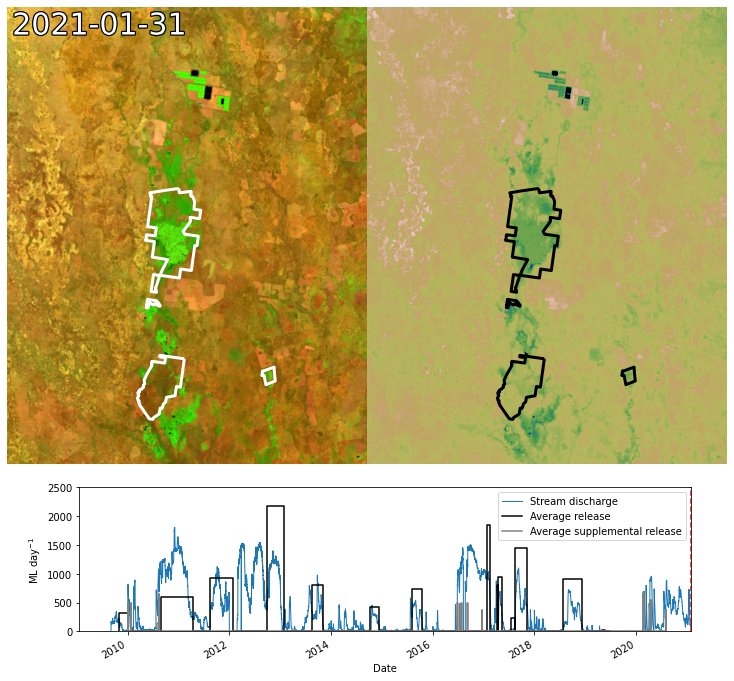

In [127]:
fig = plt.figure(figsize=(10, 10))
gs = matplotlib.gridspec.GridSpec(2, 2, left=0, bottom=0, right=1, top=1, wspace=0, hspace=0, height_ratios=(0.7, 0.3))
im0 = None
im1 = None
txt = None
txt_release = None
vline = None
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, :])
ax0.axis('off')
ax1.axis('off')
for i, (im, wo, t, dt) in enumerate(zip(ims, tqdm(wobs), interp.time.dt.strftime('%Y-%m-%d').values, interp.time.to_series().index)):
    left, bottom, right, top = interp.geobox.extent.boundingbox
    if not im0:
        im0 = ax0.imshow(im, vmin=0, vmax=1, extent=[left, right, bottom, top], interpolation='gaussian')
        im1 = ax1.imshow(wo, extent=[left, right, bottom, top], interpolation='gaussian', norm=matplotlib.colors.TwoSlopeNorm(vmin=-0.5, vcenter=-0.06, vmax=0.0), cmap='gist_earth_r')
        txt = ax0.annotate(t, **{
            'xy': (0, 1),
            'xycoords': 'axes fraction',
            'xytext': (5, -5),
            'textcoords': 'offset points',
            'horizontalalignment': 'left',
            'verticalalignment': 'top',
            'fontsize': 30,
            'color': 'white',
            'path_effects': [matplotlib.patheffects.withStroke(linewidth=2.5, foreground='black')],
        })
        txt_release = ax0.annotate('Currently releasing', **{
            'xy': (0, 0),
            'xycoords': 'axes fraction',
            'xytext': (5, 5),
            'textcoords': 'offset points',
            'horizontalalignment': 'left',
            'verticalalignment': 'bottom',
            'fontsize': 30,
            'color': 'lightblue',
            'alpha': 0,
            'path_effects': [matplotlib.patheffects.withStroke(linewidth=2.5, foreground='black')],
        })
        rgdf.plot(ax=ax0, fc='None', ec='white', lw=3)
        rgdf.plot(ax=ax1, fc='None', ec='black', lw=3)
        
        ax2.set_ylabel('ML day$^{-1}$')
        macquarie_discharge.value.plot(ax=ax2, label='Stream discharge', lw=1)
        release_series.plot(ax=ax2, label='Average release', c='k')
        release_series_supp.plot(ax=ax2, label='Average supplemental release', c='grey')
        ax2.set_xlim(interp.time[0].values, interp.time[-1].values)
        ax2.set_xlabel('Date')
        ax2.set_ylim(0, 2500)
        ax2.legend()
        vline = ax2.axvline(dt, c='red', linestyle='--')
        pos2 = ax2.get_position()
        ax2.set_position([0.1, 0.1, pos2.x1 - 0.15, pos2.y1 - 0.1])
    else:
        im0.set_data(im)
        im1.set_data(wo)
        txt.set_text(t)
        vline.set_data([dt, dt], vline.get_data()[1])
        
        if np.searchsorted(water_releases, dt) % 2:
            # In a release period
            txt_release.set_alpha(1)
        else:
            txt_release.set_alpha(0)

    fig.savefig(f'macquarie/{i}.png')